Epoch 1, Loss: 0.06863025520093895
Epoch 2, Loss: 0.020218187774580364
Epoch 3, Loss: 0.012286159944544066
Epoch 4, Loss: 0.007869805064152016
Epoch 5, Loss: 0.00852659666018172
Accuracy: 99.43240454076367%


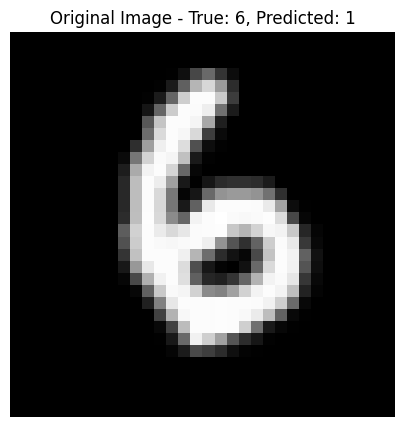

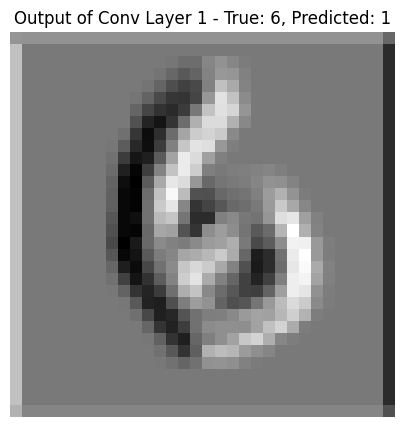

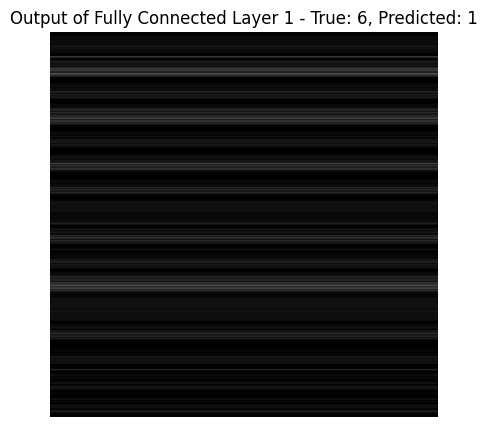

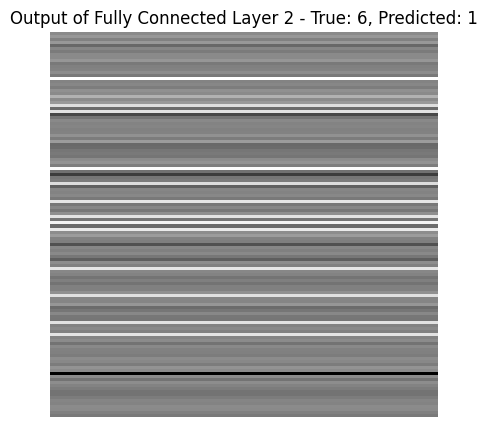

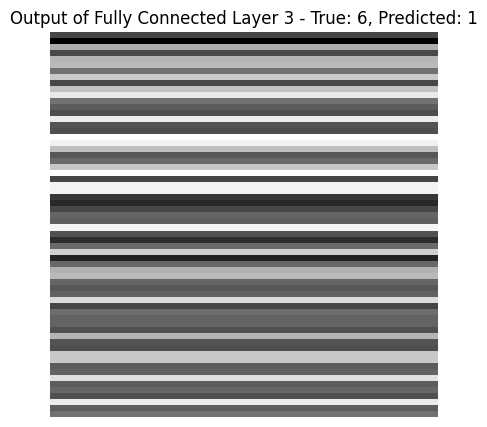

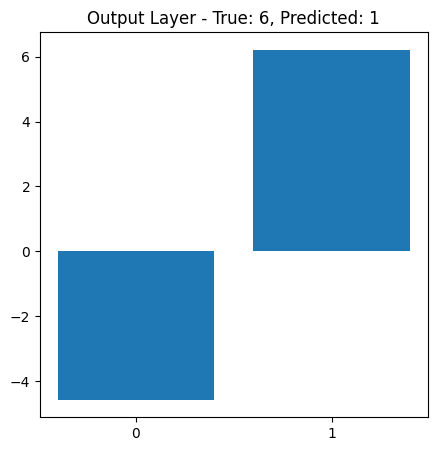

Output layer values: [-4.5718265  6.2093687]


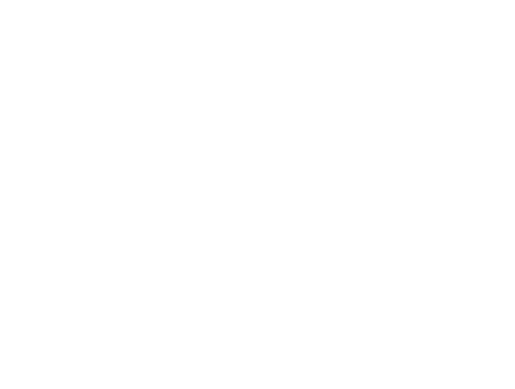

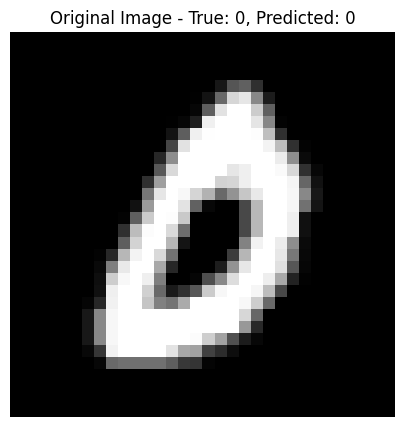

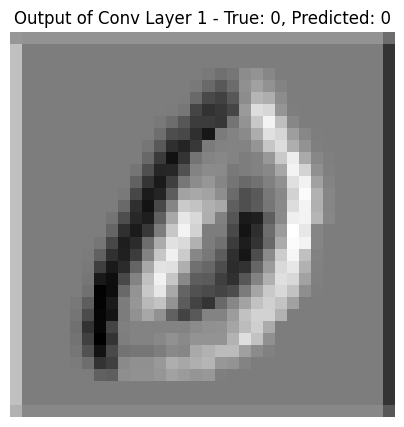

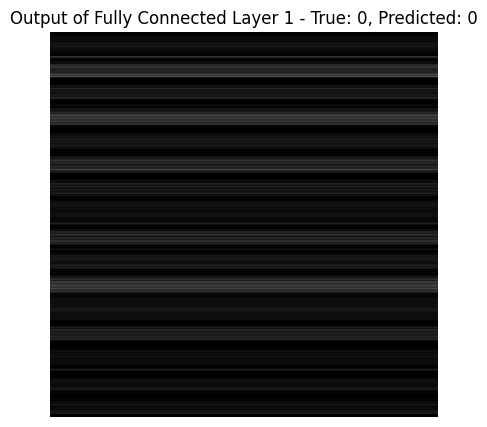

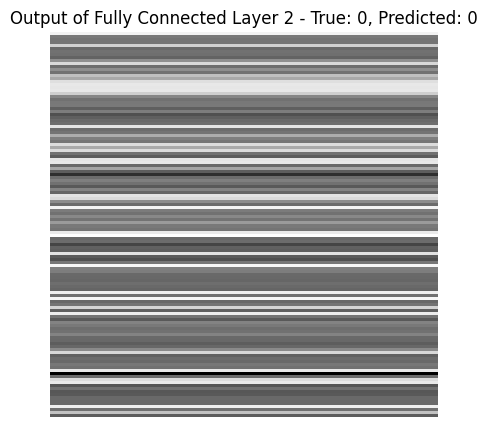

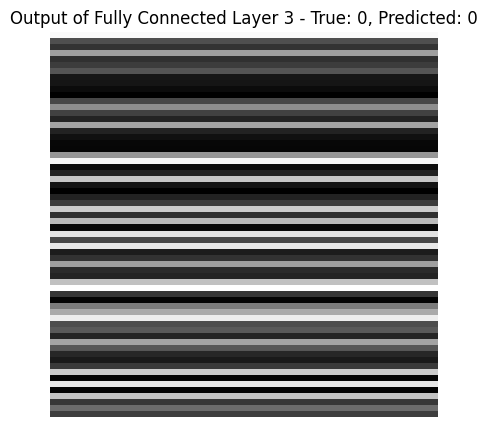

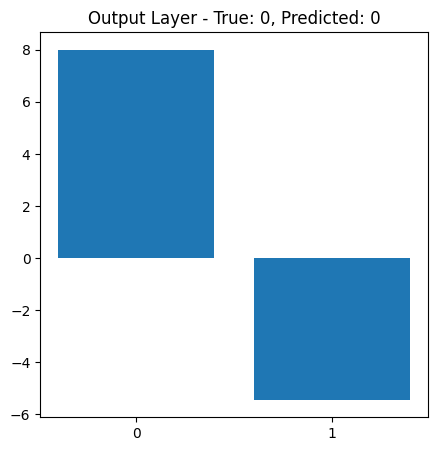

Output layer values: [ 8.00459  -5.444784]


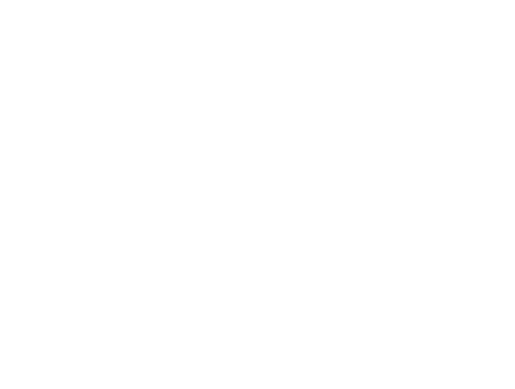

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Define the SimpleCNN class
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()

        # Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)

        # Fully connected hidden layers
        self.fc1 = nn.Linear(16*16*16, 128)  # Adjusted for MNIST (32x32 -> 16x16 after pooling)
        self.fc2 = nn.Linear(128, 64)         # Second Hidden Layer

        # Output layer
        self.out = nn.Linear(64, num_classes)
        
        # Intermediate outputs storage
        self.intermediate_outputs = []

    def forward(self, x):
        self.intermediate_outputs = []  # Clear previous outputs
        
        # Apply convolutional layer
        x = self.conv1(x)
        self.intermediate_outputs.append(x.detach())
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        self.intermediate_outputs.append(x.detach())

        # Flatten the output from the convolutional layer
        x = x.view(x.size(0), -1)
        
        # Apply fully connected hidden layer 1
        x = self.fc1(x)
        self.intermediate_outputs.append(x.detach())
        x = F.relu(x)
      
        x = self.fc2(x)
        self.intermediate_outputs.append(x.detach())
        x = F.relu(x)
      
        # Apply output layer
        x = self.out(x)
        self.intermediate_outputs.append(x.detach())
        
        return x

# Load MNIST dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Filter out only the classes 0 and 6
train_indices = [i for i, t in enumerate(mnist_train.targets) if t == 0 or t == 6]
test_indices = [i for i, t in enumerate(mnist_test.targets) if t == 0 or t == 6]

mnist_train = Subset(mnist_train, train_indices)
mnist_test = Subset(mnist_test, test_indices)

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=1, shuffle=True)

# Initialize model, loss function, and optimizer
model = SimpleCNN(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            labels = (labels == 6).long()  # Map labels 0 -> 0 and 6 -> 1
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

# Train the model
train(model, train_loader, criterion, optimizer)

# Evaluate the model
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            labels = (labels == 6).long()  # Map labels 0 -> 0 and 6 -> 1
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total}%")

# Evaluate the model on the test set
evaluate(model, test_loader)

# Function to visualize intermediate outputs
def visualize_intermediate_outputs(original_image, intermediate_outputs, predicted_label, true_label):
    # Show original image
    plt.figure(figsize=(5, 5))
    plt.title(f'Original Image - True: {true_label}, Predicted: {predicted_label}')
    plt.imshow(original_image[0, 0].cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

    # Show intermediate outputs
    for i, output in enumerate(intermediate_outputs):
        plt.figure(figsize=(5, 5))
        if i == 0:
            plt.title(f'Output of Conv Layer {i+1} - True: {true_label}, Predicted: {predicted_label}')
            plt.imshow(output[0, 0].cpu().numpy(), cmap='gray')  # Show only the first feature map
        elif i < len(intermediate_outputs) - 1:
            plt.title(f'Output of Fully Connected Layer {i} - True: {true_label}, Predicted: {predicted_label}')
            plt.imshow(output[0].cpu().numpy().reshape(-1, 1), cmap='gray', aspect='auto')
        else:
            plt.title(f'Output Layer - True: {true_label}, Predicted: {predicted_label}')
            plt.bar(range(output.size(1)), output[0].cpu().numpy())
            plt.xticks(range(output.size(1)))
            plt.show()
            print(f'Output layer values: {output[0].cpu().numpy()}')
        plt.axis('off')
        plt.show()

# Function to get a single example of a specified label
def get_example_by_label(data_loader, label):
    for img, lbl in data_loader:
        if lbl == label:
            return img, lbl.item()

# Get a single example of a 6 and a 0
img_6, lbl_6 = get_example_by_label(test_loader, 6)
img_0, lbl_0 = get_example_by_label(test_loader, 0)

# Forward pass for the 6
model.eval()
with torch.no_grad():
    output_6 = model(img_6)
    predicted_label_6 = torch.argmax(output_6, dim=1).item()
    visualize_intermediate_outputs(img_6, model.intermediate_outputs, predicted_label_6, lbl_6)

# Forward pass for the 0
with torch.no_grad():
    output_0 = model(img_0)
    predicted_label_0 = torch.argmax(output_0, dim=1).item()
    visualize_intermediate_outputs(img_0, model.intermediate_outputs, predicted_label_0, lbl_0)

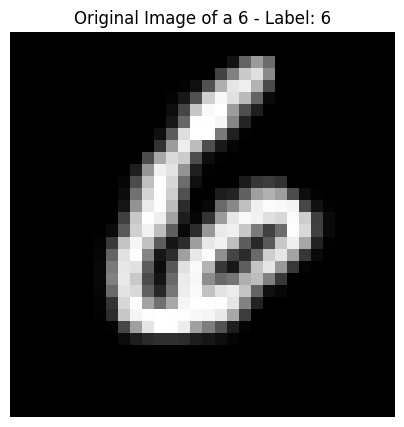

Tensor representation of the image:
tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])
Shape of the tensor: torch.Size([1, 32, 32])
Tensor ready to be fed into the model: torch.Size([1, 1, 32, 32])


In [12]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 pixels
    transforms.ToTensor(),        # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor
])

# Load the MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Function to get a single example of a specified label
def get_example_by_label(dataset, label):
    for img, lbl in dataset:
        if lbl == label:
            return img, lbl

# Get a single example of a 6
img_6, lbl_6 = get_example_by_label(mnist_train, 6)

# Display the image
plt.figure(figsize=(5, 5))
plt.title(f'Original Image of a 6 - Label: {lbl_6}')
plt.imshow(img_6[0].numpy(), cmap='gray')
plt.axis('off')
plt.show()

# Print the tensor
print("Tensor representation of the image:")
print(img_6)
print("Shape of the tensor:", img_6.shape)

# Ensure that the tensor is ready to be fed into the model
print("Tensor ready to be fed into the model:", img_6.unsqueeze(0).shape)

In [23]:
import cv2

# Load the image
image = cv2.imread('President_Barack_Obama.jpg')

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imwrite('grayscale_image.jpg', gray_image)

# Apply a more severe Gaussian blur with a larger kernel size
severe_gaussian_blur = cv2.GaussianBlur(gray_image, (31, 31), 0)
cv2.imwrite('severe_gaussian_blur.jpg', severe_gaussian_blur)

# Perform edge detection using Canny
edges = cv2.Canny(severe_gaussian_blur, 50, 150)
cv2.imwrite('canny_edges.jpg', edges)

# Resize the image
resized_image = cv2.resize(severe_gaussian_blur, (200, 200))
cv2.imwrite('resized_image.jpg', resized_image)

print("Images saved successfully.")

Images saved successfully.
